In [1]:
from model_training import *
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from neuralforecast.losses.pytorch import RMSE

c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [2]:
prefix = "NFLX"
FINAL_COLUMNS = ['mean_future', 'mean_influential','mean_trustworthy', 'mean_clickbait','norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14']
df_without_weekends = pd.read_csv("csv/"+prefix+'_without_weekends.csv')
df_without_weekends['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(df_without_weekends)]
max_date = df_without_weekends['DateGen'].max()
test_start_date = max_date - pd.DateOffset(days=59)
val_start_date = test_start_date - pd.DateOffset(days=40)
train_set, val_set, test_set = split_data(df_without_weekends, 'DateGen', val_start_date, test_start_date, start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

cols_min_max = ['^GSPC_Volume', 'NFLX_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

train_set, scaler_min_max = min_max_scale(train_set,'Date', cols_min_max, train_data=True, scaler=None)
val_set = min_max_scale(val_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)
test_set = min_max_scale(test_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

train_set = train_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
val_set = val_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
test_set = test_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
train_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
val_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
test_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
train_set['unique_id'] = prefix
val_set['unique_id'] = prefix
test_set['unique_id'] = prefix

(744, 54)
(40, 54)
(60, 54)


In [6]:
############### NBEATS #################
horizon = 5
model_name = 'NBEATS'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['seasonality', 'trend', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
n_blocks = [prms['n_blocks_season'], prms['n_blocks_trend'], prms['n_blocks_ident']]
mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*prms['num_hidden']
models = [NBEATS(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 stack_types=stack_types,
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=prms['learning_rate'],
                 n_harmonics=prms['n_harmonics'],
                 n_polynomials=prms['n_polynomials'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:51:27,717] A new study created in memory with name: no-name-c3b6beb1-58a4-4f05-90b7-b913a87e6010
Seed set to 1


744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 147.76it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.89it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.70it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 56.65it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.48it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 209.63it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.11it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 119.65it/s]

[I 2023-12-18 21:51:35,986] Trial 0 finished with value: 166.28039769905178 and parameters: {'input_size': 7, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 5, 'learning_rate': 0.05208060292448183}. Best is trial 0 with value: 166.28039769905178.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 131.75it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.06it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 322.29it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.53it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 296.52it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.05it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.39it/s] 

[I 2023-12-18 21:51:42,863] Trial 1 finished with value: 216.0770509076308 and parameters: {'input_size': 4, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 2, 'learning_rate': 0.04313409983625165}. Best is trial 0 with value: 166.28039769905178.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.19it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 139.23it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 208.65it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.51it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.62it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 508.89it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 992.26it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.36it/s]
784 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 87.74it/s] 
789 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 97.61it/s] 
794 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 65.40it/s]
799 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
804 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 153.82it

In [7]:
loss_val

166.28039769905178

In [8]:
############### NHITS #################
horizon = 5
model_name = 'NHITS'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
n_blocks = [prms['n_blocks1'], prms['n_blocks2'], prms['n_blocks3']]
mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*3
n_pool_kernel_size = [prms['n_pool_kernel_size1'], prms['n_pool_kernel_size2'], prms['n_pool_kernel_size3']]
n_freq_downsample = [prms['n_freq_downsample1'], prms['n_freq_downsample2'], prms['n_freq_downsample3']]
models = [NHITS(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 stack_types=stack_types,
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=prms['learning_rate'],
                 n_pool_kernel_size=n_pool_kernel_size,
                 n_freq_downsample=n_freq_downsample,
                 dropout_prob_theta=prms['dropout_prob_theta'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:52:27,570] A new study created in memory with name: no-name-8a2fa2eb-b67d-49d5-8032-6478006e4204
Seed set to 1


744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.45it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 387.11it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.94it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.28it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 221.51it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 53.51it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.21it/s]

[I 2023-12-18 21:52:36,190] Trial 0 finished with value: 173.88642383848813 and parameters: {'input_size': 19, 'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'n_freq_downsample1': 4, 'n_freq_downsample2': 4, 'n_freq_downsample3': 3, 'learning_rate': 0.009341722913469208, 'dropout_prob_theta': 0.27485758098995744}. Best is trial 0 with value: 173.88642383848813.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.50it/s] 
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 189.62it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.33it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 772.86it/s]

[I 2023-12-18 21:52:44,049] Trial 1 finished with value: 159.87073754039616 and parameters: {'input_size': 17, 'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'n_freq_downsample1': 4, 'n_freq_downsample2': 2, 'n_freq_downsample3': 4, 'learning_rate': 7.790845054376245e-05, 'dropout_prob_theta': 0.4100162291293383}. Best is trial 1 with value: 159.87073754039616.
Seed set to 1



744 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.35it/s]
749 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
754 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
759 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
764 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 120.17it/s]
769 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
774 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 93.23it/s]
779 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 138.17it/s]
784 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
789 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
794 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]
799 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.07it/s] 
804 5
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.33it/s] 
809 5
Predicting DataLoader 0: 100%|██████████| 1/

In [9]:
loss_val

159.87073754039616

In [5]:
############### TFT #################
horizon = 5
model_name = 'TFT'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

study = optuna.create_study(direction='minimize')
study.optimize(partial(objective, train_set=train_set, val_set=val_set, loss=loss, model_name=model_name, horizon=horizon, hist_exog_list=FINAL_COLUMNS, max_steps=max_steps, random_seed=random_seed, loss_func=loss_func, scaler_type=scaler_type), n_trials=2)
prms = study.best_trial.params
# Predykcja na podstawie najlepszych hiperparametrów
models = [TFT(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=prms['input_size'],
                 learning_rate=prms['learning_rate'],
                 hidden_size=prms['hidden_size'],
                 dropout=prms['dropout'],
                 attn_dropout=prms['attn_dropout'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]

# Pipeline, który robi predykcję batchami co ileś dni, ustalane przez horizon
loss_val, predictions_val = pipeline_train_predict(models, train_set, val_set, horizon, mean_squared_error, model_name)
# Merge train and val sets
train_val_set = pd.concat([train_set, val_set])
loss_test, predictions_test = pipeline_train_predict(models, train_val_set, test_set, horizon, mean_squared_error, model_name)

[I 2023-12-18 21:57:46,837] A new study created in memory with name: no-name-cb0c3339-c13e-451c-9bc2-270de00e36d0
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 84.92it/s]

[I 2023-12-18 21:58:00,041] Trial 0 finished with value: 375.66886641590395 and parameters: {'input_size': 3, 'learning_rate': 1.4619019934073393e-05, 'hidden_size': 12, 'dropout': 0.18289535556885061, 'attn_dropout': 0.447507788311037}. Best is trial 0 with value: 375.66886641590395.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 232.86it/s]

[I 2023-12-18 21:58:23,367] Trial 1 finished with value: 229.69487190034735 and parameters: {'input_size': 8, 'learning_rate': 0.0032831202948453196, 'hidden_size': 20, 'dropout': 0.32601738794520446, 'attn_dropout': 0.3124408660151364}. Best is trial 1 with value: 229.69487190034735.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.41it/s]


In [6]:
loss_val

229.69487190034735

In [18]:
from neuralforecast.models import DilatedRNN

models = [DilatedRNN(
                 h=horizon,
                 loss=loss,
                 max_steps=max_steps,
                 hist_exog_list=FINAL_COLUMNS,
                 input_size=10,
                 #stack_types=stack_types,
                 #mlp_units=mlp_units,
                 #n_blocks=n_blocks,
                 #learning_rate=prms['learning_rate'],
                 #n_harmonics=prms['n_harmonics'],
                 #n_polynomials=prms['n_polynomials'],
                 scaler_type=scaler_type,
                random_seed=random_seed
                 )]
model = NeuralForecast(models=models, freq='D')
model.fit(train_set)
p =  model.predict().reset_index()
p = p.merge(val_set[['ds','unique_id', 'y']].reset_index(), on=['ds', 'unique_id'], how='left')

Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 13.67it/s]


In [20]:
[6]*4

[6, 6, 6, 6]

In [19]:
p

,unique_id,ds,DilatedRNN,index,y
0,NFLX,2023-01-15,438.156189,0,441.709991
1,NFLX,2023-01-16,439.109467,1,440.209991
2,NFLX,2023-01-17,439.157562,2,444.049988
3,NFLX,2023-01-18,440.515656,3,450.380005
4,NFLX,2023-01-19,440.727509,4,441.910004


In [5]:
ts = pd.read_csv('csv/BA/train_set_full.csv')

In [6]:
ts.columns

Index(['future', 'influential', 'trustworthy', 'not clickbait',
       'finbert_Score', 'bart_Score', 'vader_Score', 'future_finbert',
       'future_bart', 'future_vader', 'influential_finbert',
       'influential_bart', 'influential_vader', 'trustworthy_finbert',
       'trustworthy_bart', 'trustworthy_vader', 'clickbait_finbert',
       'clickbait_bart', 'clickbait_vader', 'Date', 'EURUSD=X_Close',
       'mean_future', 'mean_influential', 'mean_trustworthy', 'mean_clickbait',
       'norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14', 'norm_roc_14',
       'log_return_1', 'log_return_5', 'log_return_10', 'log_return_20',
       'log_return_gspc_1', 'log_return_gspc_5', 'log_return_gspc_10',
       'log_return_gspc_20', 'target_1', 'target_5', 'target_10', 'target_20',
       'minmax_^GSPC_Volume', 'minmax_BA_Volume', 'minmax_daily_variation',
       'minmax_high_close_pressure', 'minmax_low_open_pressure',
       'minmax_low_norm', 'minmax_close_norm', 'minmax_high_norm',
       'm

In [ ]:
# Same finansowe, same newsy, finansowe + newsy
# Do zapisu: model nauczony na treningu, na treningu i walidacji
# predykcja na walidacyjnym
# predykcja na testowym
# loss na walidacyjnym
# loss na testowym
# Dla każdego znacznika: json['financial'/'news'/'financial_and_news']['TFT'/'NBEATS'/'NHITS']['params'/'loss'] - zapis
# json['BA']['financial']['loss']['val'/'test']
# Dla każdego znacznika: zapis val_pred.csv oraz test_pred.csv results/BA/financial/TFT/val_pred.csv
horizon = 5
model_name = 'TFT'
max_steps = 10
random_seed = 1
loss_func = mean_squared_error
stack_types = ['identity', 'identity', 'identity']
scaler_type = 'standard'
loss=RMSE()

def train_all(indicator, model_names, max_steps, random_seed, FINAL_COLUMNS, scaler_type='standard', loss=RMSE()):
    
    # Prepare data
    pass

In [ ]:
prefix = "NFLX"
FINAL_COLUMNS = ['mean_future', 'mean_influential','mean_trustworthy', 'mean_clickbait','norm_rsi_14', 'norm_rsi_gspc_14', 'norm_slowk_14']
df_without_weekends = pd.read_csv("csv/"+prefix+'_without_weekends.csv')
df_without_weekends['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(df_without_weekends)]
max_date = df_without_weekends['DateGen'].max()
test_start_date = max_date - pd.DateOffset(days=59)
val_start_date = test_start_date - pd.DateOffset(days=40)
train_set, val_set, test_set = split_data(df_without_weekends, 'DateGen', val_start_date, test_start_date, start_date_train = '2021-01-01')
print(train_set.shape)
print(val_set.shape)
print(test_set.shape)

cols_min_max = ['^GSPC_Volume', 'NFLX_Volume',
'daily_variation', 'high_close_pressure', 'low_open_pressure',
'low_norm', 'close_norm', 'high_norm', 'open_norm']

train_set, scaler_min_max = min_max_scale(train_set,'Date', cols_min_max, train_data=True, scaler=None)
val_set = min_max_scale(val_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)
test_set = min_max_scale(test_set,'Date', cols_min_max, train_data=False, scaler=scaler_min_max)

train_set = train_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
val_set = val_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
test_set = test_set[['DateGen', f'{prefix}_Close'] + FINAL_COLUMNS]
train_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
val_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
test_set.rename(columns={'DateGen':'ds', f'{prefix}_Close':'y'}, inplace=True)
train_set['unique_id'] = prefix
val_set['unique_id'] = prefix
test_set['unique_id'] = prefix

In [11]:
pd.read_csv('csv/'+prefix+'/train_set_full.csv')['log_return_1']

0      0.000000
1     -0.033606
2     -0.003948
3     -0.039778
4      0.016644
         ...   
651    0.002154
652    0.000000
653    0.010053
654   -0.015960
655   -0.001688
Name: log_return_1, Length: 656, dtype: float64

In [1]:
from model_training import *
import pandas as pd
import numpy as np
from scripts.essentials import *
from scripts.plots import *
from scripts.train_utilities import *
from neuralforecast.losses.pytorch import MQLoss, MSE
import json
import os
from datetime import datetime
import torch
from sklearn.metrics import mean_squared_error

def f1_score(y_true, y_pred):
    csm = count_signs_matrix(y_true.reset_index(drop=True), y_pred.reset_index(drop=True))
    return (3*csm[1][1]/(csm[1][0]+csm[1][1]) + 2*csm[1][1]/(csm[0][1]+csm[1][1]))/5

def MQLoss2(y_pred, y_test):
    # Reshape tensors to 1D
    y_pred_ = torch.tensor(y_pred.values)
    y_pred_ = y_pred_.view(-1)
    y_test_ = torch.tensor(y_test.values)
    y_test_ = y_test_.view(-1)
    # print(y_pred_.shape)
    # print(y_test_.shape)
    #print(MQLoss()(y_test, y_pred_).item())
    print(y_test_)
    print(y_pred_)
    return MQLoss()(y_test_, y_pred_).item()
    # return MQLoss(y_test_, y_pred_)

class HorizonTrainer:
    def __init__(self, prefix, mode, model_type, final_columns, train_set_all, val_set_all, test_set_all, horizon, max_steps, scaler_type, loss_func, loss, n_trials, random_seed, timestamp, target):
        self.prefix = prefix
        self.model_type = model_type
        self.mode = mode
        self.final_columns = final_columns
        self.train_set_all = train_set_all
        self.train_set = train_set_all
        self.val_set_all = val_set_all
        self.val_set = val_set_all
        self.test_set_all = test_set_all
        self.test_set = test_set_all
        self.horizon = horizon
        self.max_steps = max_steps
        self.scaler_type = scaler_type
        self.loss_func = loss_func
        self.loss = loss
        self.n_trials = n_trials
        self.random_seed = random_seed
        self.timestamp = timestamp
        self.target = target

    def __prepare_sets__(self):

        self.train_set_all['DateGen'] = pd.date_range(start='2021-01-01', end='2023-11-26', freq='D')[:len(self.train_set)]
        valid_start_date = self.train_set['DateGen'].max() + pd.DateOffset(days=1)
        self.val_set_all['DateGen'] = pd.date_range(start=valid_start_date, end='2023-11-26', freq='D')[:len(self.val_set)]
        test_start_date = self.val_set['DateGen'].max() + pd.DateOffset(days=1)
        self.test_set_all['DateGen'] = pd.date_range(start=test_start_date, end='2023-11-26', freq='D')[:len(self.test_set)]
        # self.train_set = self.train_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        # self.val_set = self.val_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        # self.test_set = self.test_set_all[['DateGen', f'{self.prefix}_Close'] + self.final_columns]
        # self.train_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        # self.val_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        # self.test_set.rename(columns={'DateGen':'ds', f'{self.prefix}_Close':'y'}, inplace=True)
        self.train_set = self.train_set_all[['DateGen', f'{self.target}'] + self.final_columns]
        self.val_set = self.val_set_all[['DateGen', f'{self.target}'] + self.final_columns]
        self.test_set = self.test_set_all[['DateGen', f'{self.target}'] + self.final_columns]
        self.train_set.rename(columns={'DateGen':'ds', f'{self.target}':'y'}, inplace=True)
        self.val_set.rename(columns={'DateGen':'ds', f'{self.target}':'y'}, inplace=True)
        self.test_set.rename(columns={'DateGen':'ds', f'{self.target}':'y'}, inplace=True)
        self.train_set['unique_id'] = self.prefix
        self.val_set['unique_id'] = self.prefix
        self.test_set['unique_id'] = self.prefix

    def train(self):
        self.__prepare_sets__()
        if self.loss_func == f1_score:
            study = optuna.create_study(direction='maximize')
        else:
            study = optuna.create_study(direction='minimize')
        study.optimize(partial(objective, train_set=self.train_set, val_set=self.val_set, loss=self.loss, model_name=self.model_type, horizon=self.horizon, hist_exog_list=self.final_columns, max_steps=self.max_steps, random_seed=self.random_seed, loss_func=self.loss_func, scaler_type=self.scaler_type), n_trials=self.n_trials)
        prms = study.best_trial.params

        if self.model_type == 'NBEATS':
            n_blocks = [prms['n_blocks_season'], prms['n_blocks_trend'], prms['n_blocks_ident']]
            mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*prms['num_hidden']
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'stack_types': ['seasonality', 'trend', 'identity'],
                'mlp_units': mlp_units,
                'n_blocks': n_blocks,
                'learning_rate': prms['learning_rate'],
                'n_harmonics': prms['n_harmonics'],
                'n_polynomials': prms['n_polynomials'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [NBEATS(**params)]

        elif self.model_type == 'NHITS':
            n_blocks = [prms['n_blocks1'], prms['n_blocks2'], prms['n_blocks3']]
            mlp_units=[[prms['mlp_units'], prms['mlp_units']]]*3
            n_pool_kernel_size = [prms['n_pool_kernel_size1'], prms['n_pool_kernel_size2'], prms['n_pool_kernel_size3']]
            #n_freq_downsample = [prms['n_freq_downsample1'], prms['n_freq_downsample2'], prms['n_freq_downsample3']]
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'stack_types': ['identity', 'identity', 'identity'],
                'mlp_units': mlp_units,
                'n_blocks': n_blocks,
                'learning_rate': prms['learning_rate'],
                'n_pool_kernel_size': n_pool_kernel_size,
                #'n_freq_downsample': n_freq_downsample,
                #'dropout_prob_theta': prms['dropout_prob_theta'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [NHITS(**params)]

        elif self.model_type == 'TFT':
            params = {
                'h': self.horizon,
                'loss': self.loss,
                'max_steps': self.max_steps,
                'hist_exog_list': self.final_columns,
                'input_size': 2*self.horizon,
                'learning_rate': prms['learning_rate'],
                'hidden_size': prms['hidden_size'],
                #'dropout': prms['dropout'],
                #'attn_dropout': prms['attn_dropout'],
                'scaler_type': self.scaler_type,
                'random_seed': self.random_seed
            }
            models = [TFT(**params)]

        else:
            raise ValueError('Wrong model type!')
        
        params['loss'] = str(params['loss'])
        
            
        loss_val, predictions_val = pipeline_train_predict(models, self.train_set, self.val_set, self.horizon, self.loss_func, self.model_type)
        predictions_val = pd.concat([predictions_val, self.val_set_all[['Date']]], axis=1)
        
        train_val_set = pd.concat([self.train_set, self.val_set])
        loss_test, predictions_test = pipeline_train_predict(models, train_val_set, self.test_set, self.horizon, self.loss_func, self.model_type)
        predictions_test = pd.concat([predictions_test, self.test_set_all[['Date']]], axis=1)
        
        # create directiories if not exist
    
        if not os.path.exists(f'results/{self.prefix}'):
            os.mkdir(f'results/{self.prefix}')
        if not os.path.exists(f'results/{self.prefix}/{self.mode}'):
            os.mkdir(f'results/{self.prefix}/{self.mode}')
        if not os.path.exists(f'results/{self.prefix}/{self.mode}/{self.model_type}'):
            os.mkdir(f'results/{self.prefix}/{self.mode}/{self.model_type}')
        # All saves
        # Save params as json
        with open(f'results/{self.prefix}/{self.mode}/{self.model_type}/params_{self.timestamp}.json', 'w') as f:
            json.dump(params, f)
        # Save predictions_val and predictions_test as csv
        predictions_val.to_csv(f'results/{self.prefix}/{self.mode}/{self.model_type}/val_pred_{self.timestamp}.csv', index=False)
        predictions_test.to_csv(f'results/{self.prefix}/{self.mode}/{self.model_type}/test_pred_{self.timestamp}.csv', index=False)
        # Save loss_val and loss_test as json
        scores = {
            'val': loss_val,
            'test': loss_test
        }
        with open(f'results/{self.prefix}/{self.mode}/{self.model_type}/loss_{self.timestamp}.json', 'w') as f:
            json.dump(scores, f)


c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] Nie można odnaleźć określonej procedury
  warn(f"Failed to load image Python extension: {e}")


In [9]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
prefix = "NFLX"
# modes = ['financial', 'news', 'financial_and_news']
# model_types = ['NBEATS', 'NHITS', 'TFT']
# final_columns = [
#     ['norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1'],
#     ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy'],
#     ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy', 'norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1']
# ]
modes = ['financial_and_news']
model_types = ['NBEATS']
final_columns = [
    # ['norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1'],
    # ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy'],
    ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy', 'norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm']
]
train_set_all = pd.read_csv('csv/'+prefix+'/train_set_full.csv')
val_set_all = pd.read_csv('csv/'+prefix+'/val_set_full.csv')
test_set_all = pd.read_csv('csv/'+prefix+'/test_set_full.csv')
horizon = 5
# max_steps = [250, 250, 50]
max_steps = [20]
scaler_type = 'standard'
loss_func = f1_score
loss=MSE()
n_trials = 3
random_seed = 1

for i, mode in enumerate(modes):
    for j, model_type in enumerate(model_types):
        print(f'Prefix: {prefix} | mode: {mode} | model_type: {model_type}')
        ht = HorizonTrainer(prefix, mode, model_type, final_columns[i], train_set_all, val_set_all, test_set_all, horizon, max_steps[j], scaler_type, loss_func, loss, n_trials, random_seed, timestamp)
        ht.train()


[I 2023-12-27 15:17:41,699] A new study created in memory with name: no-name-f40805ca-4a66-4196-ac4c-4296211d349b
Seed set to 1


Prefix: NFLX | mode: financial_and_news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.70it/s]

[I 2023-12-27 15:18:07,882] Trial 0 finished with value: 0.772258064516129 and parameters: {'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'learning_rate': 0.05063159193743755}. Best is trial 0 with value: 0.772258064516129.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 225.77it/s]

[I 2023-12-27 15:18:36,491] Trial 1 finished with value: 0.6958823529411765 and parameters: {'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 2, 'learning_rate': 2.0122753311683894e-05}. Best is trial 0 with value: 0.772258064516129.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]

[I 2023-12-27 15:19:07,143] Trial 2 finished with value: 0.7582608695652173 and parameters: {'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 1, 'learning_rate': 0.0004776288195451216}. Best is trial 0 with value: 0.772258064516129.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.97it/s] 


In [2]:
# timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
prefix = "NFLX"
modes = ['financial', 'news']
model_types = ['NBEATS', 'NHITS', 'TFT']
final_columns = [
    ['norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm'],
    ['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy'],
    #['finbert_Score', 'bart_Score', 'vader_Score', 'mean_influential', 'mean_trustworthy', 'norm_rsi_gspc_14', 'norm_rsi_14', 'norm_slowk_14', 'minmax_high_norm', 'log_return_1']
]
train_set_all = pd.read_csv('csv/'+prefix+'/train_set_full.csv')
val_set_all = pd.read_csv('csv/'+prefix+'/val_set_full.csv')
test_set_all = pd.read_csv('csv/'+prefix+'/test_set_full.csv')
horizons = [2, 5]
targets = [f'{prefix}_Close', 'log_return_1', 'log_return_5']
max_steps = [20, 20, 10]
scaler_type = 'standard'
loss=MSE()
n_trials = 3
random_seed = 1

for target in targets:
    for horizon in horizons:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        if target == f'{prefix}_Close':
            loss_func = mean_squared_error
        else:
            loss_func = f1_score
        for i, mode in enumerate(modes):
            for j, model_type in enumerate(model_types):
                print(f'Prefix: {prefix} | mode: {mode} | model_type: {model_type}')
                ht = HorizonTrainer(prefix, mode, model_type, final_columns[i], train_set_all, val_set_all, test_set_all, horizon, max_steps[j], scaler_type, loss_func, loss, n_trials, random_seed, timestamp, target)
                ht.train()


[I 2023-12-27 18:50:47,200] A new study created in memory with name: no-name-b0ae5c61-4516-4c43-b4f1-e31808d2577a
Seed set to 1


Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 323.76it/s]

[I 2023-12-27 18:52:02,142] Trial 0 finished with value: 194.2419531465276 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 4, 'learning_rate': 0.008426316121014377}. Best is trial 0 with value: 194.2419531465276.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 60.28it/s]

[I 2023-12-27 18:53:20,399] Trial 1 finished with value: 211.8503047348234 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 4, 'n_polynomials': 3, 'learning_rate': 0.0022601462359613713}. Best is trial 0 with value: 194.2419531465276.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 52.97it/s]

[I 2023-12-27 18:54:42,700] Trial 2 finished with value: 201.60825129922023 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'learning_rate': 0.013402187742846093}. Best is trial 0 with value: 194.2419531465276.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 71.17it/s] 

[I 2023-12-27 18:58:13,707] A new study created in memory with name: no-name-aeabba5e-4d45-4ab2-9bb5-9f7997f1ebaa
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.07it/s]

[I 2023-12-27 18:59:45,417] Trial 0 finished with value: 26993902.360090863 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 1, 'learning_rate': 0.0992325396426077}. Best is trial 0 with value: 26993902.360090863.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 395.43it/s]

[I 2023-12-27 19:01:19,308] Trial 1 finished with value: 210.15182122299453 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'learning_rate': 0.0001141473913068866}. Best is trial 1 with value: 210.15182122299453.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 72.39it/s]

[I 2023-12-27 19:02:47,972] Trial 2 finished with value: 219.97926820381548 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 2, 'learning_rate': 2.369216133726877e-05}. Best is trial 1 with value: 210.15182122299453.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 634.35it/s]

[I 2023-12-27 19:06:51,401] A new study created in memory with name: no-name-bc9d404e-4fb7-4d3d-a070-1ba65012025f
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 340.23it/s]

[I 2023-12-27 19:08:37,332] Trial 0 finished with value: 215.57388961412948 and parameters: {'learning_rate': 0.00021878728762492227, 'hidden_size': 32}. Best is trial 0 with value: 215.57388961412948.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 145.85it/s]

[I 2023-12-27 19:10:23,167] Trial 1 finished with value: 192.02604594586893 and parameters: {'learning_rate': 0.0010841668464641855, 'hidden_size': 28}. Best is trial 1 with value: 192.02604594586893.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 19:12:06,465] Trial 2 finished with value: 244.81195039455787 and parameters: {'learning_rate': 0.021784972978666824, 'hidden_size': 24}. Best is trial 1 with value: 192.02604594586893.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 76.98it/s]

[I 2023-12-27 19:16:18,605] A new study created in memory with name: no-name-4e0ed8ff-6957-44c2-b8fe-8b67fcd8b890
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.07it/s]

[I 2023-12-27 19:17:41,623] Trial 0 finished with value: 225.04895174077245 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 5, 'learning_rate': 1.644909866812828e-05}. Best is trial 0 with value: 225.04895174077245.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 274.48it/s]

[I 2023-12-27 19:18:59,247] Trial 1 finished with value: 201.91415765238935 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 1, 'learning_rate': 0.06732296052575899}. Best is trial 1 with value: 201.91415765238935.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 135.10it/s]

[I 2023-12-27 19:20:19,786] Trial 2 finished with value: 214.17119077197285 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'learning_rate': 0.00011302520294374461}. Best is trial 1 with value: 201.91415765238935.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 19:23:33,202] A new study created in memory with name: no-name-437760fe-d164-42a7-be71-3818642b7c2e
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 130.78it/s]

[I 2023-12-27 19:25:14,899] Trial 0 finished with value: 147.49607371548205 and parameters: {'n_blocks1': 3, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 1, 'learning_rate': 0.0025149677929521413}. Best is trial 0 with value: 147.49607371548205.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 312.82it/s]

[I 2023-12-27 19:26:46,068] Trial 1 finished with value: 192.4982448522235 and parameters: {'n_blocks1': 3, 'n_blocks2': 2, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 2, 'learning_rate': 0.00285884060237973}. Best is trial 0 with value: 147.49607371548205.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.43it/s]

[I 2023-12-27 19:28:16,013] Trial 2 finished with value: 187.4441450516694 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 3, 'mlp_units': 128, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'learning_rate': 0.03656365417258768}. Best is trial 0 with value: 147.49607371548205.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 187.64it/s]

[I 2023-12-27 19:32:35,882] A new study created in memory with name: no-name-9dabf13e-7e4f-4aeb-bad8-34978b23cda2
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.46it/s]

[I 2023-12-27 19:34:04,800] Trial 0 finished with value: 197.5424368384296 and parameters: {'learning_rate': 0.0024172598840406607, 'hidden_size': 4}. Best is trial 0 with value: 197.5424368384296.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.06it/s]

[I 2023-12-27 19:35:33,085] Trial 1 finished with value: 218.676454021712 and parameters: {'learning_rate': 6.783070388396254e-05, 'hidden_size': 4}. Best is trial 0 with value: 197.5424368384296.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 227.91it/s]

[I 2023-12-27 19:37:12,978] Trial 2 finished with value: 228.66942899245777 and parameters: {'learning_rate': 0.01811317904451828, 'hidden_size': 24}. Best is trial 0 with value: 197.5424368384296.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 19:40:57,666] A new study created in memory with name: no-name-23aa3455-7771-447b-abb7-1547d12b5173
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 127.73it/s]

[I 2023-12-27 19:41:33,784] Trial 0 finished with value: 152.86387875343235 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'learning_rate': 0.0013329498496175666}. Best is trial 0 with value: 152.86387875343235.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 576.22it/s]

[I 2023-12-27 19:42:06,029] Trial 1 finished with value: 166.40200614114318 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 4, 'learning_rate': 0.0022142976543750945}. Best is trial 0 with value: 152.86387875343235.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 215.26it/s]

[I 2023-12-27 19:42:40,136] Trial 2 finished with value: 221.86705447000023 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 2, 'learning_rate': 2.0837987924145733e-05}. Best is trial 0 with value: 152.86387875343235.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.17it/s]

[I 2023-12-27 19:44:11,995] A new study created in memory with name: no-name-b1406270-a35f-4c1d-9ea0-5a0333aeb3bf
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.79it/s]

[I 2023-12-27 19:44:49,922] Trial 0 finished with value: 336.99454306699363 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'learning_rate': 0.007160111202370424}. Best is trial 0 with value: 336.99454306699363.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 51.75it/s]

[I 2023-12-27 19:45:25,303] Trial 1 finished with value: 180.4315270403636 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'learning_rate': 0.00024487338832168633}. Best is trial 1 with value: 180.4315270403636.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.85it/s]

[I 2023-12-27 19:46:03,830] Trial 2 finished with value: 156.749692603946 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 2, 'learning_rate': 2.1699408062050564e-05}. Best is trial 2 with value: 156.749692603946.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 124.14it/s]

[I 2023-12-27 19:47:39,526] A new study created in memory with name: no-name-cbdc1fe9-3c33-40d5-a78e-c944d9bac856
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s]

[I 2023-12-27 19:48:20,256] Trial 0 finished with value: 418.1188584276939 and parameters: {'learning_rate': 0.00028396253924311383, 'hidden_size': 4}. Best is trial 0 with value: 418.1188584276939.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 275.61it/s]

[I 2023-12-27 19:49:04,530] Trial 1 finished with value: 250.05736852479177 and parameters: {'learning_rate': 0.0002740971140777402, 'hidden_size': 12}. Best is trial 1 with value: 250.05736852479177.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s]

[I 2023-12-27 19:49:45,455] Trial 2 finished with value: 490.97343379268403 and parameters: {'learning_rate': 2.1552497338062897e-05, 'hidden_size': 8}. Best is trial 1 with value: 250.05736852479177.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 313.90it/s]

[I 2023-12-27 19:51:39,322] A new study created in memory with name: no-name-0b439a21-b432-4759-aed0-95c1916c2f2f
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 186.70it/s]

[I 2023-12-27 19:52:20,217] Trial 0 finished with value: 173.8338438872018 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'learning_rate': 0.0009170734077169037}. Best is trial 0 with value: 173.8338438872018.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.24it/s]

[I 2023-12-27 19:52:57,777] Trial 1 finished with value: 192.38788486947334 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 3, 'learning_rate': 0.010229290090426758}. Best is trial 0 with value: 173.8338438872018.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 19:53:32,928] Trial 2 finished with value: 161.18976554947466 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 2, 'learning_rate': 0.0004275826165513168}. Best is trial 2 with value: 161.18976554947466.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 508.77it/s]

[I 2023-12-27 19:55:01,752] A new study created in memory with name: no-name-a6893bc5-1bf3-4920-ae55-a602bd9e0abf
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 116.59it/s]

[I 2023-12-27 19:55:38,559] Trial 0 finished with value: 164.90504936152163 and parameters: {'n_blocks1': 3, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 3, 'learning_rate': 0.00011841915765966078}. Best is trial 0 with value: 164.90504936152163.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 497.19it/s]

[I 2023-12-27 19:56:16,484] Trial 1 finished with value: 207.20945659792073 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.009787392075522906}. Best is trial 0 with value: 164.90504936152163.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.93it/s]

[I 2023-12-27 19:56:57,647] Trial 2 finished with value: 160.1582268575209 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 2, 'learning_rate': 0.000637773963970088}. Best is trial 2 with value: 160.1582268575209.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.06it/s]

[I 2023-12-27 19:58:38,973] A new study created in memory with name: no-name-a9f5bedc-a7d2-4bca-868e-af09c2e24876
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.43it/s]

[I 2023-12-27 19:59:27,508] Trial 0 finished with value: 235.74333581163108 and parameters: {'learning_rate': 0.005690881149213277, 'hidden_size': 16}. Best is trial 0 with value: 235.74333581163108.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 142.08it/s]

[I 2023-12-27 20:00:13,092] Trial 1 finished with value: 192.26186898348413 and parameters: {'learning_rate': 0.02577272686074656, 'hidden_size': 8}. Best is trial 1 with value: 192.26186898348413.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 20:01:02,130] Trial 2 finished with value: 304.06050650728866 and parameters: {'learning_rate': 1.839962864351748e-05, 'hidden_size': 12}. Best is trial 1 with value: 192.26186898348413.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.03it/s]

[I 2023-12-27 20:02:59,957] A new study created in memory with name: no-name-0c6c3e89-ff60-4e51-ad06-ff9196b2f52b
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 150.51it/s]

[I 2023-12-27 20:04:27,112] Trial 0 finished with value: 0.46764705882352936 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 1, 'learning_rate': 0.019553772580571033}. Best is trial 0 with value: 0.46764705882352936.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 204.01it/s]

[I 2023-12-27 20:05:46,424] Trial 1 finished with value: 0.5129411764705882 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 4, 'learning_rate': 0.002023816238192758}. Best is trial 1 with value: 0.5129411764705882.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.96it/s]

[I 2023-12-27 20:07:08,892] Trial 2 finished with value: 0.55119825708061 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 4, 'learning_rate': 0.0019516501963741976}. Best is trial 2 with value: 0.55119825708061.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.02it/s]

[I 2023-12-27 20:10:42,661] A new study created in memory with name: no-name-2677145a-acd9-4375-8ce7-6a1840c3786d
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.52it/s]

[I 2023-12-27 20:12:26,983] Trial 0 finished with value: 0.4507739938080496 and parameters: {'n_blocks1': 3, 'n_blocks2': 3, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 1, 'learning_rate': 0.01533401671119421}. Best is trial 0 with value: 0.4507739938080496.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 320.54it/s]

[I 2023-12-27 20:14:12,598] Trial 1 finished with value: 0.3098039215686274 and parameters: {'n_blocks1': 3, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'learning_rate': 0.0001997010333737244}. Best is trial 0 with value: 0.4507739938080496.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.25it/s]

[I 2023-12-27 20:15:36,757] Trial 2 finished with value: 0.40261437908496733 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.002332310037746937}. Best is trial 0 with value: 0.4507739938080496.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.75it/s]

[I 2023-12-27 20:19:43,019] A new study created in memory with name: no-name-f051ce30-845d-4ef8-b36f-603a77bde3ac
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 112.58it/s]

[I 2023-12-27 20:21:30,583] Trial 0 finished with value: 0.6235294117647059 and parameters: {'learning_rate': 0.020872845519212948, 'hidden_size': 32}. Best is trial 0 with value: 0.6235294117647059.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 74.79it/s] 

[I 2023-12-27 20:23:16,632] Trial 1 finished with value: 0.5574660633484163 and parameters: {'learning_rate': 1.513524514303846e-05, 'hidden_size': 28}. Best is trial 0 with value: 0.6235294117647059.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.76it/s]

[I 2023-12-27 20:24:49,080] Trial 2 finished with value: 0.48907563025210077 and parameters: {'learning_rate': 0.038136856349816256, 'hidden_size': 4}. Best is trial 0 with value: 0.6235294117647059.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 104.15it/s]

[I 2023-12-27 20:29:25,955] A new study created in memory with name: no-name-82308b7e-2410-4fc0-b606-923690b7afcc
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 122.18it/s]

[I 2023-12-27 20:30:59,007] Trial 0 finished with value: 0.24117647058823533 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 2, 'learning_rate': 2.6049666586688852e-05}. Best is trial 0 with value: 0.24117647058823533.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 20:32:33,715] Trial 1 finished with value: 0.4741687979539642 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 1, 'learning_rate': 0.005352548860445602}. Best is trial 1 with value: 0.4741687979539642.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 100.26it/s]

[I 2023-12-27 20:34:00,885] Trial 2 finished with value: 0.4741687979539642 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'learning_rate': 0.03018544348561157}. Best is trial 1 with value: 0.4741687979539642.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.63it/s]

[I 2023-12-27 20:37:50,351] A new study created in memory with name: no-name-1a612480-43b9-4dad-a5d4-0314ca356876
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.55it/s]

[I 2023-12-27 20:39:19,834] Trial 0 finished with value: 0.46764705882352936 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 64, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 3, 'learning_rate': 0.029946250989078306}. Best is trial 0 with value: 0.46764705882352936.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 96.01it/s]

[I 2023-12-27 20:40:51,997] Trial 1 finished with value: 0.24117647058823533 and parameters: {'n_blocks1': 3, 'n_blocks2': 3, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 3, 'learning_rate': 2.1756607712788766e-05}. Best is trial 0 with value: 0.46764705882352936.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 172.75it/s]

[I 2023-12-27 20:42:20,667] Trial 2 finished with value: 0.5067873303167421 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 2, 'mlp_units': 32, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 3, 'learning_rate': 0.021233726084412603}. Best is trial 2 with value: 0.5067873303167421.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 80.62it/s]

[I 2023-12-27 20:46:02,081] A new study created in memory with name: no-name-20ad9bf6-6bc8-484e-aac6-0e677c8b0b33
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 89.59it/s] 

[I 2023-12-27 20:47:37,223] Trial 0 finished with value: 0.6807843137254903 and parameters: {'learning_rate': 0.00019494718650438748, 'hidden_size': 4}. Best is trial 0 with value: 0.6807843137254903.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 20:49:26,700] Trial 1 finished with value: 0.6013071895424836 and parameters: {'learning_rate': 4.5807369285682176e-05, 'hidden_size': 28}. Best is trial 0 with value: 0.6807843137254903.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 196.61it/s]

[I 2023-12-27 20:51:12,634] Trial 2 finished with value: 0.40261437908496733 and parameters: {'learning_rate': 0.0002605164691006754, 'hidden_size': 20}. Best is trial 0 with value: 0.6807843137254903.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.83it/s]

[I 2023-12-27 20:55:08,574] A new study created in memory with name: no-name-f847906a-dfe9-4b15-90d4-184241ca336f
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.08it/s]

[I 2023-12-27 20:55:45,015] Trial 0 finished with value: 0.579539641943734 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'learning_rate': 0.048794683863959284}. Best is trial 0 with value: 0.579539641943734.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 168.26it/s]

[I 2023-12-27 20:56:19,327] Trial 1 finished with value: 0.2253869969040248 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 2, 'learning_rate': 0.0014408380305010943}. Best is trial 0 with value: 0.579539641943734.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 115.03it/s]

[I 2023-12-27 20:56:56,743] Trial 2 finished with value: 0.5071207430340557 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 2, 'learning_rate': 8.457851568881981e-05}. Best is trial 0 with value: 0.579539641943734.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 443.19it/s]

[I 2023-12-27 20:58:28,063] A new study created in memory with name: no-name-3b524ff2-a7cd-442c-b5da-57f9ca5dc2c8
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 61.05it/s]

[I 2023-12-27 20:59:10,684] Trial 0 finished with value: 0.5010893246187363 and parameters: {'n_blocks1': 3, 'n_blocks2': 3, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.04267787072943645}. Best is trial 0 with value: 0.5010893246187363.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 3054.85it/s]

[I 2023-12-27 20:59:47,775] Trial 1 finished with value: 0.49568627450980396 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 64, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 2, 'learning_rate': 0.0007910019503925216}. Best is trial 0 with value: 0.5010893246187363.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.73it/s] 

[I 2023-12-27 21:00:26,576] Trial 2 finished with value: 0.579539641943734 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.000333646951638192}. Best is trial 2 with value: 0.579539641943734.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 21:02:05,919] A new study created in memory with name: no-name-79154fe4-945a-479c-8782-cffd937601b3
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 397.41it/s]

[I 2023-12-27 21:02:54,622] Trial 0 finished with value: 0.583529411764706 and parameters: {'learning_rate': 0.002577491694464552, 'hidden_size': 16}. Best is trial 0 with value: 0.583529411764706.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.39it/s] 

[I 2023-12-27 21:03:43,598] Trial 1 finished with value: 0.6807843137254903 and parameters: {'learning_rate': 0.00019886352165969544, 'hidden_size': 12}. Best is trial 1 with value: 0.6807843137254903.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.66it/s] 

[I 2023-12-27 21:04:28,502] Trial 2 finished with value: 0.583529411764706 and parameters: {'learning_rate': 0.05371861430986545, 'hidden_size': 4}. Best is trial 1 with value: 0.6807843137254903.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.84it/s]

[I 2023-12-27 21:06:31,451] A new study created in memory with name: no-name-8fac7da0-4e39-499a-8986-c1b123771cb3
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.11it/s]

[I 2023-12-27 21:07:14,015] Trial 0 finished with value: 0.6322250639386189 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 2, 'n_polynomials': 5, 'learning_rate': 1.6328225956308555e-05}. Best is trial 0 with value: 0.6322250639386189.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 297.47it/s]

[I 2023-12-27 21:07:55,033] Trial 1 finished with value: 0.5294117647058824 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 2, 'learning_rate': 3.147788542231296e-05}. Best is trial 0 with value: 0.6322250639386189.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 21:08:41,327] Trial 2 finished with value: 0.5010893246187363 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 4, 'learning_rate': 0.0008649718537752358}. Best is trial 0 with value: 0.6322250639386189.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 498.08it/s]

[I 2023-12-27 21:10:29,224] A new study created in memory with name: no-name-0214e69f-010c-4f2a-b3e1-81825b1dc392
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 118.78it/s]

[I 2023-12-27 21:11:09,483] Trial 0 finished with value: 0.6322250639386189 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 3, 'mlp_units': 64, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'learning_rate': 0.000737755373895744}. Best is trial 0 with value: 0.6322250639386189.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 456.70it/s]

[I 2023-12-27 21:11:47,306] Trial 1 finished with value: 0.6417112299465241 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 64, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.00041869739107755786}. Best is trial 1 with value: 0.6417112299465241.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 134.01it/s]

[I 2023-12-27 21:12:28,654] Trial 2 finished with value: 0.5529411764705883 and parameters: {'n_blocks1': 3, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 1, 'learning_rate': 6.590452464020706e-05}. Best is trial 1 with value: 0.6417112299465241.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 180.64it/s]

[I 2023-12-27 21:14:02,399] A new study created in memory with name: no-name-a1893048-375d-4d8a-922e-db9886f24937
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.89it/s]

[I 2023-12-27 21:14:59,583] Trial 0 finished with value: 0.5347593582887701 and parameters: {'learning_rate': 0.0007556490703645633, 'hidden_size': 24}. Best is trial 0 with value: 0.5347593582887701.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 277.71it/s]

[I 2023-12-27 21:15:45,841] Trial 1 finished with value: 0.6213235294117647 and parameters: {'learning_rate': 0.011551165659666487, 'hidden_size': 8}. Best is trial 1 with value: 0.6213235294117647.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 98.74it/s]

[I 2023-12-27 21:16:36,683] Trial 2 finished with value: 0.632156862745098 and parameters: {'learning_rate': 8.844391998405512e-05, 'hidden_size': 12}. Best is trial 2 with value: 0.632156862745098.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.63it/s]

[I 2023-12-27 21:18:41,106] A new study created in memory with name: no-name-4a53dbe8-dfe2-4f98-9549-37ad6c4577bb
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 64.01it/s]

[I 2023-12-27 21:20:12,257] Trial 0 finished with value: 0.6263636363636363 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 3, 'learning_rate': 0.04451346988818291}. Best is trial 0 with value: 0.6263636363636363.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 21:21:41,223] Trial 1 finished with value: 0.7847619047619048 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 3, 'learning_rate': 0.08829092905484154}. Best is trial 1 with value: 0.7847619047619048.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 21:23:07,490] Trial 2 finished with value: 0.7657894736842106 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 5, 'learning_rate': 0.0002468645569756153}. Best is trial 1 with value: 0.7847619047619048.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 264.54it/s]

[I 2023-12-27 21:26:49,683] A new study created in memory with name: no-name-07544fcb-f2e0-4542-86c3-f5522a600678
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.17it/s]

[I 2023-12-27 21:28:38,135] Trial 0 finished with value: 0.7847619047619048 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 3, 'learning_rate': 1.121253680013063e-05}. Best is trial 0 with value: 0.7847619047619048.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 113.12it/s]

[I 2023-12-27 21:30:15,918] Trial 1 finished with value: 0.7847619047619048 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 32, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 2, 'learning_rate': 0.0010150568129948553}. Best is trial 0 with value: 0.7847619047619048.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 162.90it/s]

[I 2023-12-27 21:31:48,563] Trial 2 finished with value: 0.6266666666666667 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 3, 'learning_rate': 0.03645514084208752}. Best is trial 0 with value: 0.7847619047619048.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 343.74it/s]

[I 2023-12-27 21:36:20,361] A new study created in memory with name: no-name-8c2c8a8d-b328-48e1-abe8-53a1c185a644
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.13it/s]

[I 2023-12-27 21:38:12,686] Trial 0 finished with value: 0.8 and parameters: {'learning_rate': 0.018234835620977576, 'hidden_size': 20}. Best is trial 0 with value: 0.8.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.12it/s]

[I 2023-12-27 21:39:55,150] Trial 1 finished with value: 0.495 and parameters: {'learning_rate': 0.00015853367566334624, 'hidden_size': 8}. Best is trial 0 with value: 0.8.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 222.72it/s]

[I 2023-12-27 21:41:51,227] Trial 2 finished with value: 0.7847619047619048 and parameters: {'learning_rate': 0.0058331016358380465, 'hidden_size': 28}. Best is trial 0 with value: 0.8.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 128.79it/s]

[I 2023-12-27 21:46:27,923] A new study created in memory with name: no-name-d6cdedae-cd6c-4118-8432-ef73248c4393
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 163.69it/s]

[I 2023-12-27 21:48:04,763] Trial 0 finished with value: 0.7227272727272727 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 2, 'learning_rate': 1.1975579961748119e-05}. Best is trial 0 with value: 0.7227272727272727.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 289.94it/s]

[I 2023-12-27 21:49:37,481] Trial 1 finished with value: 0.7311111111111112 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 3, 'learning_rate': 0.0001873765573816776}. Best is trial 1 with value: 0.7311111111111112.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 176.68it/s]

[I 2023-12-27 21:51:13,769] Trial 2 finished with value: 0.7 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 1, 'learning_rate': 0.020782288532358344}. Best is trial 1 with value: 0.7311111111111112.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 165.35it/s]

[I 2023-12-27 21:55:07,057] A new study created in memory with name: no-name-18c366ae-760c-459e-b2e4-bf36e3ec3b79
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 459.45it/s]

[I 2023-12-27 21:56:45,543] Trial 0 finished with value: 0.7709090909090909 and parameters: {'n_blocks1': 1, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 2, 'learning_rate': 0.05217969694635568}. Best is trial 0 with value: 0.7709090909090909.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 58.78it/s]

[I 2023-12-27 21:58:33,881] Trial 1 finished with value: 0.6636842105263158 and parameters: {'n_blocks1': 3, 'n_blocks2': 2, 'n_blocks3': 1, 'mlp_units': 128, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 2, 'learning_rate': 0.0319572012764943}. Best is trial 0 with value: 0.7709090909090909.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 59.88it/s]

[I 2023-12-27 22:00:24,417] Trial 2 finished with value: 0.7618518518518519 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 1, 'learning_rate': 0.039012997940145844}. Best is trial 0 with value: 0.7709090909090909.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 69.59it/s]

[I 2023-12-27 22:04:32,853] A new study created in memory with name: no-name-6f149f55-e223-43ed-90c9-8c3a0c2f5415
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.86it/s]

[I 2023-12-27 22:06:22,679] Trial 0 finished with value: 0.47000000000000003 and parameters: {'learning_rate': 6.608353246346496e-05, 'hidden_size': 16}. Best is trial 0 with value: 0.47000000000000003.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 272.39it/s]

[I 2023-12-27 22:08:11,621] Trial 1 finished with value: 0.47000000000000003 and parameters: {'learning_rate': 0.00013368671990616796, 'hidden_size': 16}. Best is trial 0 with value: 0.47000000000000003.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 114.46it/s]

[I 2023-12-27 22:10:03,601] Trial 2 finished with value: 0.47000000000000003 and parameters: {'learning_rate': 0.0002189613985830208, 'hidden_size': 16}. Best is trial 0 with value: 0.47000000000000003.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 311.03it/s]

[I 2023-12-27 22:14:33,342] A new study created in memory with name: no-name-daccadc5-974e-4daa-8097-4566262dba81
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 415.20it/s]

[I 2023-12-27 22:15:14,134] Trial 0 finished with value: 0.7 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 2, 'n_harmonics': 5, 'n_polynomials': 2, 'learning_rate': 1.3352869776281826e-05}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 200.78it/s]

[I 2023-12-27 22:15:52,220] Trial 1 finished with value: 0.8066666666666666 and parameters: {'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 5, 'learning_rate': 0.00036151210180567433}. Best is trial 1 with value: 0.8066666666666666.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.70it/s]

[I 2023-12-27 22:16:29,562] Trial 2 finished with value: 0.78 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 3, 'n_polynomials': 4, 'learning_rate': 0.0008796997653205443}. Best is trial 1 with value: 0.8066666666666666.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 212.45it/s]

[I 2023-12-27 22:18:07,772] A new study created in memory with name: no-name-67b224bc-0551-4eb0-94ff-08b3174dd3f2
Seed set to 1



Prefix: NFLX | mode: financial | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 22:18:48,834] Trial 0 finished with value: 0.521304347826087 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 3, 'learning_rate': 0.008839792614050018}. Best is trial 0 with value: 0.521304347826087.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 317.05it/s]

[I 2023-12-27 22:19:31,264] Trial 1 finished with value: 0.4818181818181818 and parameters: {'n_blocks1': 1, 'n_blocks2': 3, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 3, 'n_pool_kernel_size2': 2, 'n_pool_kernel_size3': 3, 'learning_rate': 0.0055352229281079215}. Best is trial 0 with value: 0.521304347826087.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 451.15it/s]

[I 2023-12-27 22:20:10,251] Trial 2 finished with value: 0.5599999999999999 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 2, 'mlp_units': 64, 'n_pool_kernel_size1': 2, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'learning_rate': 0.004477618809000947}. Best is trial 2 with value: 0.5599999999999999.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 57.95it/s]

[I 2023-12-27 22:21:49,281] A new study created in memory with name: no-name-1f630b23-35b4-4823-9d41-b314e64fc21b
Seed set to 1



Prefix: NFLX | mode: financial | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 19.34it/s]

[I 2023-12-27 22:22:49,762] Trial 0 finished with value: 0.6958823529411765 and parameters: {'learning_rate': 0.013027762765352063, 'hidden_size': 24}. Best is trial 0 with value: 0.6958823529411765.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 75.28it/s]

[I 2023-12-27 22:23:58,823] Trial 1 finished with value: 0.6958823529411765 and parameters: {'learning_rate': 0.013562672715622646, 'hidden_size': 24}. Best is trial 0 with value: 0.6958823529411765.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 55.27it/s]

[I 2023-12-27 22:24:50,424] Trial 2 finished with value: 0.506 and parameters: {'learning_rate': 0.004304764658803508, 'hidden_size': 8}. Best is trial 0 with value: 0.6958823529411765.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 276.71it/s]

[I 2023-12-27 22:27:33,158] A new study created in memory with name: no-name-a7160f4f-dc24-41b9-bebc-fb681ebe084f
Seed set to 1



Prefix: NFLX | mode: news | model_type: NBEATS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<?, ?it/s]

[I 2023-12-27 22:28:13,756] Trial 0 finished with value: 0.717037037037037 and parameters: {'n_blocks_season': 1, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 4, 'learning_rate': 0.00021288942050785194}. Best is trial 0 with value: 0.717037037037037.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.31it/s]

[I 2023-12-27 22:28:55,689] Trial 1 finished with value: 0.6353846153846154 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 2, 'n_polynomials': 4, 'learning_rate': 0.030437999652751593}. Best is trial 0 with value: 0.717037037037037.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 126.52it/s]

[I 2023-12-27 22:29:37,547] Trial 2 finished with value: 0.7006896551724138 and parameters: {'n_blocks_season': 3, 'n_blocks_trend': 1, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 5, 'n_polynomials': 2, 'learning_rate': 1.7297784025631263e-05}. Best is trial 0 with value: 0.717037037037037.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 121.81it/s]

[I 2023-12-27 22:31:16,556] A new study created in memory with name: no-name-5fcb97e6-7130-45f5-8731-c9099f558dcc
Seed set to 1



Prefix: NFLX | mode: news | model_type: NHITS
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 45.67it/s]

[I 2023-12-27 22:32:04,441] Trial 0 finished with value: 0.7 and parameters: {'n_blocks1': 1, 'n_blocks2': 1, 'n_blocks3': 3, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 3, 'n_pool_kernel_size3': 1, 'learning_rate': 0.00016210929379393302}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 63.85it/s]

[I 2023-12-27 22:32:50,781] Trial 1 finished with value: 0.6642857142857143 and parameters: {'n_blocks1': 2, 'n_blocks2': 1, 'n_blocks3': 1, 'mlp_units': 32, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 1, 'learning_rate': 1.2424157416984262e-05}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 133.16it/s]

[I 2023-12-27 22:33:38,871] Trial 2 finished with value: 0.7582608695652173 and parameters: {'n_blocks1': 2, 'n_blocks2': 2, 'n_blocks3': 2, 'mlp_units': 128, 'n_pool_kernel_size1': 1, 'n_pool_kernel_size2': 1, 'n_pool_kernel_size3': 3, 'learning_rate': 0.005091931572740299}. Best is trial 2 with value: 0.7582608695652173.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.18it/s]

[I 2023-12-27 22:35:38,749] A new study created in memory with name: no-name-90618844-ebf2-47cf-9a93-e3423759e4bb
Seed set to 1



Prefix: NFLX | mode: news | model_type: TFT
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 201.47it/s]

[I 2023-12-27 22:36:34,680] Trial 0 finished with value: 0.7 and parameters: {'learning_rate': 0.00021374652891850934, 'hidden_size': 24}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 241.86it/s]

[I 2023-12-27 22:37:20,343] Trial 1 finished with value: 0.3 and parameters: {'learning_rate': 1.3581703403704284e-05, 'hidden_size': 8}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 105.41it/s]

[I 2023-12-27 22:38:16,202] Trial 2 finished with value: 0.7 and parameters: {'learning_rate': 0.00021971137038628256, 'hidden_size': 24}. Best is trial 0 with value: 0.7.
Seed set to 1



Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 198.66it/s]


In [12]:
str(RMSE())

'RMSE()'

In [12]:
# C:\Users\szymo\LBN-INZ\CODE\model_training\results\NFLX\financial_and_news\NBEATS\val_pred_20231225_134506.csv
# C:\Users\szymo\LBN-INZ\CODE\model_training\results\NFLX\financial_and_news\NBEATS\val_pred_20231226_002730.csv
val = pd.read_csv('results/NFLX/financial_and_news/NBEATS/val_pred_20231226_002730.csv')
test = pd.read_csv('results/NFLX/financial_and_news/NBEATS/test_pred_20231226_002730.csv')

In [13]:
test

,unique_id,ds,NBEATS,index,y,modelID,sequenceID,Date
0,NFLX,2022-11-28,0.001725,0.0,0.012381,0.0,0.0,2023-09-04
1,NFLX,2022-11-29,0.006401,1.0,-0.031677,0.0,1.0,2023-09-05
2,NFLX,2022-11-30,-0.039050,2.0,-0.078175,1.0,0.0,2023-09-06
3,NFLX,2022-12-01,-0.032065,3.0,-0.101197,1.0,1.0,2023-09-07
4,NFLX,2022-12-02,-0.117686,4.0,-0.109333,2.0,0.0,2023-09-08
5,NFLX,2022-12-03,-0.102125,5.0,-0.121517,2.0,1.0,2023-09-11
6,NFLX,2022-12-04,-0.127835,6.0,-0.092714,3.0,0.0,2023-09-12
7,NFLX,2022-12-05,-0.122013,7.0,-0.064991,3.0,1.0,2023-09-13
8,NFLX,2022-12-06,-0.074278,8.0,-0.041656,4.0,0.0,2023-09-14
9,NFLX,2022-12-07,-0.066630,9.0,-0.044114,4.0,1.0,2023-09-15


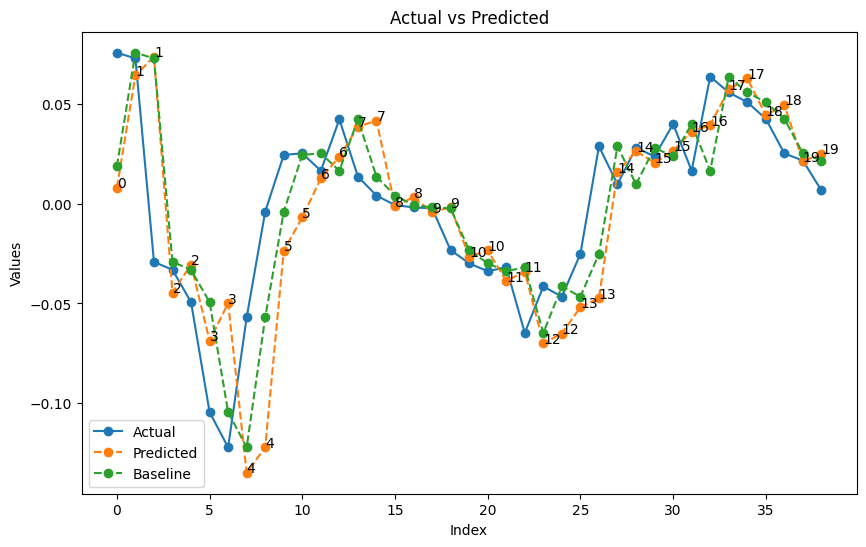

In [14]:
plot_actual_vs_predicted(val['y'][1:].reset_index(drop=True), val['NBEATS'][1:].reset_index(drop=True), val['y'].shift(1)[1:].reset_index(drop=True), val['modelID'][1:].reset_index(drop=True))

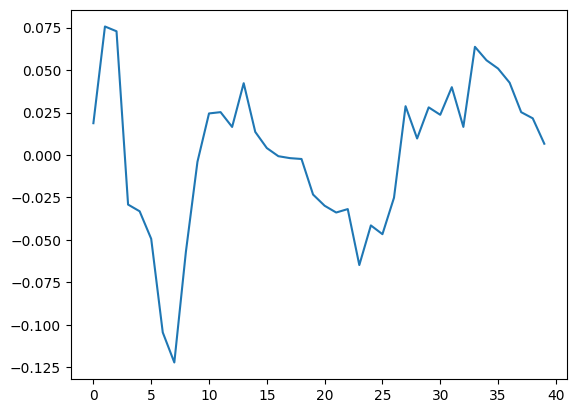

In [11]:
# plot of target_5 from val_set_all
import matplotlib.pyplot as plt
val_set_all = pd.read_csv('csv/NFLX/val_set_full.csv')
plt.plot(val_set_all['target_5'])


In [5]:
train_set_all = pd.read_csv('csv/'+prefix+'/train_set_full.csv')

In [22]:
count_signs_matrix(val['y'].reset_index(drop=True), val['NBEATS'].reset_index(drop=True))

array([[ 8, 14],
       [ 6, 11]])

In [15]:
# p['y'][:-1],p['y'].shift(-1)[:(len(p['y'])-1)]
count_signs_matrix(test['y'][1:],test['y'].shift(1)[:(len(test['y'])-1)])

array([[14, 13],
       [12, 17]])

In [3]:
val_nbeats = pd.read_csv('results/NFLX/financial/NBEATS/val_pred.csv')
test_nbeats = pd.read_csv('results/NFLX/financial/NBEATS/test_pred.csv')
val_nhits = pd.read_csv('results/NFLX/financial/NHITS/val_pred.csv')
test_nhits = pd.read_csv('results/NFLX/financial/NHITS/test_pred.csv')
val_tft = pd.read_csv('results/NFLX/financial/TFT/val_pred.csv')
test_tft = pd.read_csv('results/NFLX/financial/TFT/test_pred.csv')

In [5]:
df_train = pd.DataFrame({'NBEATS': val_nbeats['NBEATS'], 'NHITS': val_nhits['NHITS'], 'TFT': val_tft['TFT'], 'y': val_nbeats['y']})

In [6]:
df_test = pd.DataFrame({'NBEATS': test_nbeats['NBEATS'], 'NHITS': test_nhits['NHITS'], 'TFT': test_tft['TFT'], 'y': test_nbeats['y']})

In [10]:
df = pd.concat([df_train, df_test])
df_train = df.iloc[:-5]
df_test = df.iloc[-5:]

In [12]:
len(df_test)

5

In [13]:
# apply catboost to df_train
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X_train, y_train, X_test, y_test = df_train[['NBEATS', 'NHITS', 'TFT']], df_train['y'], df_test[['NBEATS', 'NHITS', 'TFT']], df_test['y']

model = CatBoostRegressor(iterations=10000,
                            learning_rate=0.1,
                            loss_function='RMSE',
                            verbose=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

0:	learn: 28.2594311	total: 1.23ms	remaining: 12.3s
1:	learn: 26.4876187	total: 1.94ms	remaining: 9.69s
2:	learn: 24.9852089	total: 2.63ms	remaining: 8.76s
3:	learn: 23.4364856	total: 3.24ms	remaining: 8.09s
4:	learn: 22.0049523	total: 4.01ms	remaining: 8.01s
5:	learn: 20.6765867	total: 4.79ms	remaining: 7.98s
6:	learn: 19.6505677	total: 5.7ms	remaining: 8.14s
7:	learn: 18.5831818	total: 6.4ms	remaining: 8s
8:	learn: 17.8545284	total: 7.02ms	remaining: 7.79s
9:	learn: 17.1473301	total: 8.41ms	remaining: 8.4s
10:	learn: 16.5067299	total: 9.19ms	remaining: 8.34s
11:	learn: 15.8215345	total: 9.87ms	remaining: 8.22s
12:	learn: 15.1911378	total: 10.5ms	remaining: 8.09s
13:	learn: 14.7390586	total: 11.1ms	remaining: 7.95s
14:	learn: 14.2191616	total: 11.8ms	remaining: 7.89s
15:	learn: 13.7583191	total: 12.7ms	remaining: 7.91s
16:	learn: 13.3736033	total: 13.3ms	remaining: 7.79s
17:	learn: 12.9253942	total: 14ms	remaining: 7.77s
18:	learn: 12.5642868	total: 14.7ms	remaining: 7.71s
19:	learn: 

199.39882798249386

In [14]:
np.sqrt(mean_squared_error(y_test, y_pred))

14.120864987049973

In [18]:
import torch

In [20]:
MQLoss()(torch.tensor(y_pred), torch.tensor(y_test.values)).item()

1.3154746187540376

In [3]:
y_test.values

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 y_test.values                                                                                │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'y_test' is not defined

In [12]:
y_test = torch.tensor(np.array([1,2,3,4]))
y_pred = torch.tensor(np.array([4,3,2,1]))
MQLoss()(y_test, y_pred).item()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 y_test = torch.tensor(np.array([1,2,3,4]))                                                   │
│   2 y_pred = torch.tensor(np.array([4,3,2,1]))                                                   │
│ ❱ 3 MQLoss()(y_test, y_pred).item()                                                              │
│   4                                                                                              │
│                                                                                                  │
│ c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralforecast\losses\p │
│ ytorch.py:587 in __call__                                                                        │
│                                                                                                  │
│    584 │   │   sq = torch.maximum(-error, torch.zeros_like(error))                               │
│    585 │   │   s1_q = torch.maximum(error, torch.zeros_like(error))                              │
│    586 │   │   losses = (1 / len(self.quantiles)) * (                                            │
│ ❱  587 │   │   │   self.quantiles * sq + (1 - self.quantiles) * s1_q                             │
│    588 │   │   )                                                                                 │
│    589 │   │                                                                                     │
│    590 │   │   if y_hat.ndim == 3:  # BaseWindows                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: The size of tensor a (5) must match the size of tensor b (4) at non-singleton dimension 1

In [11]:
test_set_all['target_1'].tail()

55    0.001011
56    0.006401
57    0.000000
58    0.003258
59         NaN
Name: target_1, dtype: float64

In [27]:
# t1 = [ 0.0088,  0.0078,  0.0074,  0.0059,  0.0065,  0.0191,  0.0188,  0.0173,
#          0.0174,  0.0159,  0.0045,  0.0024,  0.0010, -0.0010,  0.0023,  0.0332,
#          0.0329,  0.0307,  0.0250,  0.0275,  0.0208,  0.0209,  0.0192,  0.0189,
#          0.0197,  0.0148,  0.0139,  0.0135,  0.0146,  0.0135,  0.0100,  0.0104,
#          0.0084,  0.0084,  0.0090,  0.0051,  0.0056,  0.0049,  0.0031,  0.0036]
t1 = [ 0.0088,  0.0078,  0.0074,  0.0059,  0.0065, 10]
# t2 = [-0.0034,  0.0087,  0.0142, -0.0190,  0.0183,  0.0535,  0.0059, -0.0879,
#         -0.0229,  0.0020, -0.0016, -0.0118, -0.0227,  0.0301,  0.0305, -0.0008,
#         -0.0205,  0.0030,  0.0014,  0.0210, -0.0056, -0.0217,  0.0025, -0.0195,
#          0.0144, -0.0096, -0.0197, -0.0304,  0.0038,  0.0093,  0.0119,  0.0342,
#         -0.0494,  0.0221,  0.0049,  0.0281,  0.0108, -0.0023,  0.0142,  0.0000]
t2 = [-0.0034,  0.0087,  0.0142, -0.0190,  0.018, 10]

In [28]:
# MQLoss()(t1, t2).item()
print(t1)
MQLoss()(torch.tensor(t1), torch.tensor(t2)).item()

[0.0088, 0.0078, 0.0074, 0.0059, 0.0065, 10]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:3                                                                                    │
│                                                                                                  │
│   1 # MQLoss()(t1, t2).item()                                                                    │
│   2 print(t1)                                                                                    │
│ ❱ 3 MQLoss()(torch.tensor(t1), torch.tensor(t2)).item()                                          │
│   4                                                                                              │
│                                                                                                  │
│ c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\neuralforecast\losses\p │
│ ytorch.py:587 in __call__                                                                        │
│                                                                                                  │
│    584 │   │   sq = torch.maximum(-error, torch.zeros_like(error))                               │
│    585 │   │   s1_q = torch.maximum(error, torch.zeros_like(error))                              │
│    586 │   │   losses = (1 / len(self.quantiles)) * (                                            │
│ ❱  587 │   │   │   self.quantiles * sq + (1 - self.quantiles) * s1_q                             │
│    588 │   │   )                                                                                 │
│    589 │   │                                                                                     │
│    590 │   │   if y_hat.ndim == 3:  # BaseWindows                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: The size of tensor a (5) must match the size of tensor b (6) at non-singleton dimension 1

In [30]:
MQLoss(torch.tensor(t1), torch.tensor(t2))

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 MQLoss(torch.tensor(t1), torch.tensor(t2)).item                                              │
│   2                                                                                              │
│                                                                                                  │
│ c:\Users\szymo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module │
│ .py:1695 in __getattr__                                                                          │
│                                                                                                  │
│   1692 │   │   │   modules = self.__dict__['_modules']                                           │
│   1693 │   │   │   if name in modules:                                                           │
│   1694 │   │   │   │   return modules[name]                                                      │
│ ❱ 1695 │   │   raise AttributeError(f"'{type(self).__name__}' object has no attribute '{name}'"  │
│   1696 │                                                                                         │
│   1697 │   def __setattr__(self, name: str, value: Union[Tensor, 'Module']) -> None:             │
│   1698 │   │   def remove_from(*dicts_or_sets):                                                  │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'MQLoss' object has no attribute 'item'

In [12]:
d = f1_score

In [13]:
d == f1_score

True